# Imports

In [21]:
%load_ext autoreload
%autoreload 2
from ast import literal_eval
import functools
import json
import os
import random
import shutil

# Scienfitic packages
import numpy as np
import pandas as pd
import torch
import datasets
from torch import cuda
torch.set_grad_enabled(False)

# Visuals
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(context="notebook",
        rc={"font.size":16,
            "axes.titlesize":16,
            "axes.labelsize":16,
            "xtick.labelsize": 16.0,
            "ytick.labelsize": 16.0,
            "legend.fontsize": 16.0})
palette_ = sns.color_palette("Set1")
palette = palette_[2:5] + palette_[7:]
sns.set_theme(style='whitegrid')

# Utilities

from general_utils import (
  ModelAndTokenizer,
  make_inputs,
  decode_tokens,
  find_token_range,
  predict_from_input,
)

from patchscopes_utils import *

from tqdm import tqdm
tqdm.pandas()

In [2]:
model_to_hook = {
    "EleutherAI/pythia-6.9b": set_hs_patch_hooks_neox,
    "EleutherAI/pythia-12b": set_hs_patch_hooks_neox,
    "meta-llama/Llama-2-13b-hf": set_hs_patch_hooks_llama,
    "lmsys/vicuna-7b-v1.5": set_hs_patch_hooks_llama,
    "./stable-vicuna-13b": set_hs_patch_hooks_llama,
    "CarperAI/stable-vicuna-13b-delta": set_hs_patch_hooks_llama,
    "EleutherAI/gpt-j-6b": set_hs_patch_hooks_gptj
}

In [3]:
# Load model 1

model_name_1 = "EleutherAI/pythia-6.9b"
sos_tok_1 = False

if "13b" in model_name_1 or "12b" in model_name_1:
    torch_dtype = torch.float16
else:
    torch_dtype = None

mt_1 = ModelAndTokenizer(
    model_name_1,
    low_cpu_mem_usage=True,
    device="cuda",
    torch_dtype=torch.bfloat16
)
mt_1.set_hs_patch_hooks = model_to_hook[model_name_1]
mt_1.model.eval()
mt_1.model.to(mt_1.device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50432, 4096)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=4096, out_features=12288, bias=True)
          (dense): Linear(in_features=4096, out_features=4096, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=4096, out_features=16384, bias=True)
          (dense_4h_to_h): Linear(in_features=16384, out_features=4096, bias=True)

In [7]:
import gc
gc.collect()
torch.cuda.empty_cache()
mt_2 = mt_1
sos_tok_2 = sos_tok_1
model_name_2 = model_name_1
model_name_1_ = model_name_1.strip('./')
model_name_2_ = model_name_1_

# Next token prediction

In [8]:
from datasets import load_dataset
pile_dataset = load_dataset("monology/pile-uncopyrighted", streaming=True, split='train')
pile_dataset = pile_dataset.shuffle(seed=42)

trn_n = 200 # small dataset for testing
val_n = 10
pile_trn = []
pile_val = []

# Take first trn_n examples for training
for i, example in enumerate(pile_dataset):
    if i < trn_n:
        pile_trn.append(example['text'])
    elif i < trn_n + val_n:
        pile_val.append(example['text'])
    else:
        break

sentences = [(x, 'train') for x in pile_trn] + [(x, 'validation') for x in pile_val]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

In [13]:
max_len = 256

data = {}
for sentence, split in tqdm(sentences):
    
    inp_1_ = make_inputs(mt_1.tokenizer, [sentence], device=mt_1.device)
    inp_2_ = make_inputs(mt_2.tokenizer, [sentence], device=mt_2.device)
    position = None
    k = 0
    while k<10:
        position_tmp = random.randint(
            0, min(max_len - 1, 
                   len(inp_1_['input_ids'][0]) - 1, 
                   len(inp_2_['input_ids'][0]) - 1)
        )
        # cut the tokenized input at the sampled position and turn it back into a string.
        # add some buffer at the end such that the tokenization is not modified around the sampled position.
        prefix_1 = mt_1.tokenizer.decode(inp_1_['input_ids'][0][:position_tmp + int(sos_tok_1) + 5])
        prefix_2 = mt_2.tokenizer.decode(inp_2_['input_ids'][0][:position_tmp + int(sos_tok_2) + 5])
        
        # check that the selected position corresponds to the same part of the string by 
        # comparing the prefixes until the sampled position. also make sure that this re-tokenization
        # does not shift the sampled position off the sequence length.
        inp_1 = make_inputs(mt_1.tokenizer, [prefix_1], device=mt_1.device)
        inp_2 = make_inputs(mt_2.tokenizer, [prefix_2], device=mt_2.device)
        if prefix_1 == prefix_2 and position_tmp < min(len(inp_1['input_ids'][0]), 
                                                       len(inp_2['input_ids'][0])):
            position = position_tmp
            break
        k += 1
    if position is None:
        continue
    
    for mt, model_name, inp, sos_tok in zip(
        [mt_1, mt_2],
        [model_name_1, model_name_2],
        [inp_1, inp_2],
        [sos_tok_1, sos_tok_2]
    ):
        position_ = position + int(sos_tok)
        if (prefix_1, position_, split, model_name) not in data:
            output = mt.model(**inp, output_hidden_states = True)

            data[(prefix_1, position_, split, model_name)] =  [
                output["hidden_states"][layer+1][0][position_].detach().float().cpu().numpy()
                for layer in range(mt.num_layers)
            ]

df = pd.Series(data).reset_index()
df.columns = ['full_text', 'position', 'data_split', 'model_name', 'hidden_rep']   

# Create output directory if it doesn't exist
os.makedirs('outputs', exist_ok=True)

for model_name in [model_name_1, model_name_2]:
    # Create model-specific output directory
    os.makedirs(os.path.dirname(f"outputs/{model_name}_pile_trn_val.pkl"), exist_ok=True)
    df[df['model_name'] == model_name].to_pickle(f"outputs/{model_name}_pile_trn_val.pkl")

100%|██████████| 210/210 [00:13<00:00, 15.68it/s]


In [14]:
# Pad and unpad 

pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
unpad = lambda x: x[:,:-1]

In [15]:
layer_sources = [l for l in range(0, mt_1.num_layers, 5)]
layer_targets = [l for l in range(0, mt_2.num_layers, 5)]

In [26]:
output_dir = f'{model_name_1}_{model_name_2_}_mappings_pile'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
df_trn_1 = pd.DataFrame(df[(df['data_split'] == 'train') & 
                           (df['model_name'] == model_name_1)]['hidden_rep'].to_list(), 
                        columns=[layer for layer in range(mt_1.num_layers)])
df_trn_2 = pd.DataFrame(df[(df['data_split'] == 'train') & 
                           (df['model_name'] == model_name_2)]['hidden_rep'].to_list(), 
                        columns=[layer for layer in range(mt_2.num_layers)])

layer_sources = [l for l in range(0, mt_1.num_layers, 5)]
layer_targets = [l for l in range(0, mt_2.num_layers, 5)]

mappings = {}
for layer_source in tqdm(layer_sources):
    for layer_target in layer_targets:
        X = np.array(
            df_trn_1[layer_source].values.tolist()
        )
        Y = np.array(
            df_trn_2[layer_target].values.tolist()
        )

        # Solve the least squares problem X * A = Y
        # to find our transformation matrix A
        A, res, rank, s = np.linalg.lstsq(pad(X), pad(Y))
        transform = lambda x: unpad(pad(x) @ A)

        mappings[(layer_source, layer_target)] = A
        with open(f'{model_name_1}_{model_name_2_}_mappings_pile/mapping_{layer_source}-{layer_target}.npy', 'wb') as fd:
            np.save(fd, A)

        print(layer_source, layer_target, "max error on train:", np.abs(Y - transform(X)).max())

shutil.make_archive(output_dir, 'zip', output_dir)

  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_416/3176932371.py:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  A, res, rank, s = np.linalg.lstsq(pad(X), pad(Y))


0 0 max error on train: 2.6645352591003757e-13
0 5 max error on train: 1.6484591469634324e-12
0 10 max error on train: 2.0463630789890885e-12
0 15 max error on train: 2.3447910280083306e-12
0 20 max error on train: 2.8137492336099967e-12
0 25 max error on train: 3.666400516522117e-12


 14%|█▍        | 1/7 [00:21<02:09, 21.52s/it]

0 30 max error on train: 3.211653165635653e-12
5 0 max error on train: 4.263256414560601e-13
5 5 max error on train: 2.2737367544323206e-12
5 10 max error on train: 1.4068746168049984e-12
5 15 max error on train: 2.7284841053187847e-12
5 20 max error on train: 5.4569682106375694e-12
5 25 max error on train: 6.366462912410498e-12


 29%|██▊       | 2/7 [00:41<01:43, 20.63s/it]

5 30 max error on train: 8.412825991399586e-12
10 0 max error on train: 3.936406756110955e-12
10 5 max error on train: 3.751665644813329e-12
10 10 max error on train: 3.410605131648481e-12
10 15 max error on train: 5.002220859751105e-12
10 20 max error on train: 2.1373125491663814e-11
10 25 max error on train: 2.000888343900442e-11


 43%|████▎     | 3/7 [01:01<01:20, 20.20s/it]

10 30 max error on train: 2.205524651799351e-11
15 0 max error on train: 9.805489753489383e-13
15 5 max error on train: 1.9326762412674725e-12
15 10 max error on train: 2.5011104298755527e-12
15 15 max error on train: 2.7853275241795927e-12
15 20 max error on train: 8.640199666842818e-12
15 25 max error on train: 1.000444171950221e-11


 57%|█████▋    | 4/7 [01:22<01:02, 20.73s/it]

15 30 max error on train: 5.6843418860808015e-12
20 0 max error on train: 5.542233338928781e-13
20 5 max error on train: 1.7053025658242404e-12
20 10 max error on train: 2.2737367544323206e-12
20 15 max error on train: 1.8189894035458565e-12
20 20 max error on train: 1.5063505998114124e-12
20 25 max error on train: 3.183231456205249e-12


 71%|███████▏  | 5/7 [01:44<00:42, 21.05s/it]

20 30 max error on train: 2.0889956431346945e-12
25 0 max error on train: 6.536993168992922e-13
25 5 max error on train: 4.774847184307873e-12
25 10 max error on train: 5.002220859751105e-12
25 15 max error on train: 4.774847184307873e-12
25 20 max error on train: 2.7284841053187847e-12
25 25 max error on train: 1.9326762412674725e-12


 86%|████████▌ | 6/7 [02:05<00:21, 21.23s/it]

25 30 max error on train: 3.467448550509289e-12
30 0 max error on train: 9.094947017729282e-13
30 5 max error on train: 4.774847184307873e-12
30 10 max error on train: 4.092726157978177e-12
30 15 max error on train: 3.637978807091713e-12
30 20 max error on train: 2.7853275241795927e-12
30 25 max error on train: 2.9558577807620168e-12


100%|██████████| 7/7 [02:26<00:00, 20.92s/it]

30 30 max error on train: 2.0463630789890885e-12


'/root/interpretability/patchscopes/code/EleutherAI/pythia-6.9b_EleutherAI/pythia-6.9b_mappings_pile.zip'

In [11]:
mappings = {}
for layer_source in tqdm(layer_sources):
    for layer_target in layer_targets:
        with open(f'{model_name_1}_{model_name_2_}_mappings_pile/mapping_{layer_source}-{layer_target}.npy', 'rb') as fd:
            A = np.load(fd)
        mappings[(layer_source, layer_target)] = A

100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


In [17]:
# Re-organize validation set

# First get validation data and group by text
df_val = df[(df['data_split'] == 'validation')]

# Split into model 1 and model 2 data
df_val_1 = df_val[df_val['model_name'] == model_name_1]
df_val_2 = df_val[df_val['model_name'] == model_name_2]

# Merge the two dataframes
df_val = pd.merge(
    df_val_1[['full_text', 'position', 'model_name', 'hidden_rep']],
    df_val_2[['full_text', 'position', 'model_name', 'hidden_rep']], 
    on='full_text',
    suffixes=('_1', '_2')
)

In [23]:
# Evaluate linear mappings on the validation set of WikiText/a sample from the Pile

records = []
for layer_source in tqdm(layer_sources):
    for layer_target in tqdm(layer_targets):
        A = mappings[(layer_source, layer_target)]
        transform = lambda x: torch.tensor(
            np.squeeze(
                unpad(np.dot(
                    pad(np.expand_dims(x.detach().float().cpu().numpy(), 0)), 
                    A
                ))
            )
        ).to(mt_2.device)

        for idx, row in df_val.iterrows():
            prompt = row['full_text']
            position_source = row['position_1']
            position_target = row['position_2']
            prec_1, surprisal = evaluate_patch_next_token_prediction_x_model(
                mt_1, mt_2, prompt, prompt, layer_source, layer_target,
                position_source, position_target, position_prediction=position_target, transform=transform)

            records.append({'layer_source': layer_source,
                            'layer_target': layer_target,
                            'position_source': position_source,
                            'position_target': position_target,
                            'prec_1': prec_1, 
                            'surprisal': surprisal})
        

results = pd.DataFrame.from_records(records)
results.to_csv(f'{model_name_1}_{model_name_2_}_mappings_pile_eval.csv')

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [01:38<00:00, 14.13s/it]


<Axes: xlabel='layer_target', ylabel='layer_source'>

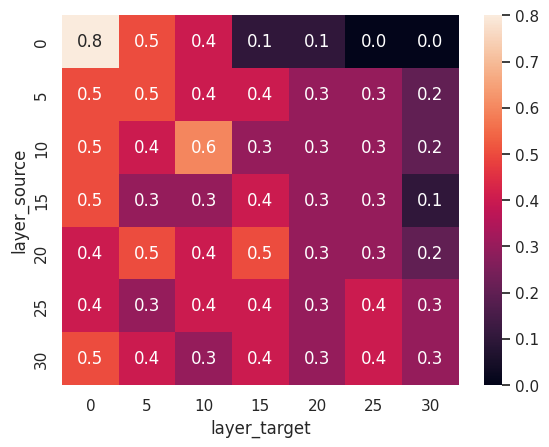

In [24]:
# Plot the resulted heatmap
metric = 'prec_1'
tmp = results[['layer_source', 'layer_target', metric]].groupby(['layer_source', 'layer_target']).agg("mean").reset_index()
tmp = tmp.pivot(index='layer_source', columns='layer_target', values=metric)

sns.heatmap(tmp, annot=True, fmt=".1f")

In [25]:
# Evaluate identity mapping on the validation set of WikiText

records = []
for layer_source in tqdm(layer_sources):
    for layer_target in tqdm(layer_targets):
        for idx, row in df_val.iterrows():
            prompt = row['full_text']
            position_source = row['position_1']
            position_target = row['position_2']
            prec_1, surprisal = evaluate_patch_next_token_prediction_x_model(
                mt_1, mt_2, prompt, prompt, layer_source, layer_target,
                position_source, position_target, position_prediction=position_target)

            records.append({'layer_source': layer_source,
                            'layer_target': layer_target,
                            'position_source': position_source,
                            'position_target': position_target,
                            'prec_1': prec_1, 
                            'surprisal': surprisal})
        
results = pd.DataFrame.from_records(records)
results.to_csv(f'{model_name_1}_{model_name_2_}_identity_pile_eval.csv')

100%|██████████| 7/7 [00:52<00:00,  7.53s/it]


In [26]:
# Evaluate the ID prompt on the validation set of WikiText

prompt_target = "cat -> cat\n1135 -> 1135\nhello -> hello\n?"
position_target = -1

records = []
for layer_source in tqdm(layer_sources):
    for layer_target in tqdm(layer_targets):
        for idx, row in df_val.iterrows():
            prompt_source = row['full_text']
            position_source = row['position_1']
            prec_1, surprisal = evaluate_patch_next_token_prediction_x_model(
                mt_1, mt_2, prompt_source, prompt_target, layer_source, layer_target,
                position_source, position_target, position_prediction=position_target, transform=None)

            records.append({'layer_source': layer_source,
                            'layer_target': layer_target,
                            'position_source': position_source,
                            'position_target': position_target,
                            'prec_1': prec_1, 
                            'surprisal': surprisal})
        
results = pd.DataFrame.from_records(records)
results.to_csv(f'{model_name_1}_{model_name_2_}_prompt-id_pile_eval.csv')

100%|██████████| 7/7 [00:48<00:00,  6.90s/it]


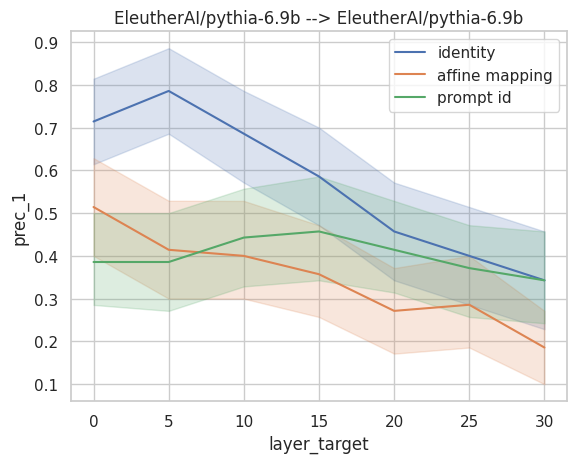

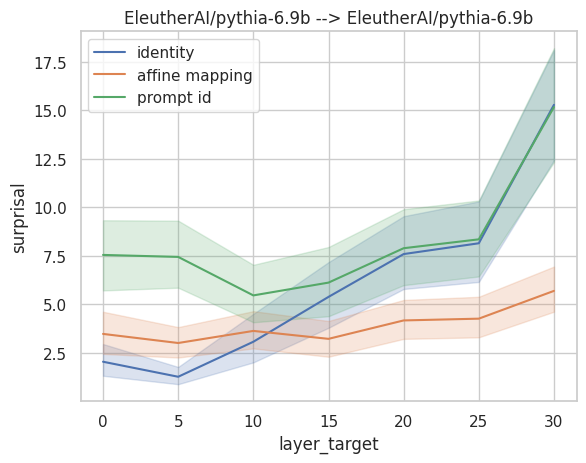

<Figure size 640x480 with 0 Axes>

In [29]:
results1 = pd.read_csv(f'{model_name_1}_{model_name_2_}_identity_pile_eval.csv')
results1["variant"] = "identity"
results2 = pd.read_csv(f'{model_name_1}_{model_name_2_}_mappings_pile_eval.csv')
results2["variant"] = "affine mapping"
results3 = pd.read_csv(f'{model_name_1}_{model_name_2_}_prompt-id_pile_eval.csv')
results3["variant"] = "prompt id"

results = pd.concat([results1, results2, results3], ignore_index=True)

for metric in ['prec_1', 'surprisal']:
    ax = sns.lineplot(data=results, x='layer_target', y=metric, hue="variant")
    ax.set_title(f"{model_name_1.strip('./')} --> {model_name_2_}")
    ax.legend_.set_title('')
    plt.show()
    plt.clf()